In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Simple nonlinear model example with thetad=1, xd=1
def nonlinear_model(theta, x):
    thetad, Ns = theta.shape
    xd, Nx = x.shape
    assert thetad == 1 and xd == 1

    return np.square(x).T @ np.power(theta,3) + np.exp(-abs(0.2-x)).T @ theta

# Assumes Gaussian noise model: y(theta, x) = G(theta, x) + epsilon,  where epsilon ~ N(0, var)
# y(theta,x) should be a single scalar output
def expected_information(Ns, Nx, x_sampler, prior_sampler, model, noise_var=1e-4):
    def gaussian_1d(x, mu, var):
        return 1/np.sqrt(2*np.pi*var) * np.exp((-0.5/var)*np.square(x-mu))

    def fix_shape(x):
        x = np.atleast_1d(np.squeeze(x))
        if len(x.shape) == 1:
            x = x[np.newaxis, :]
        return x

    # Sample experimental input locations x
    x_samples = fix_shape(x_sampler(Nx))  # (xd, Nx)
    xd = x_samples.shape[0]

    # Sample the prior
    theta_samples = fix_shape(prior_sampler(Ns))  # (thetad, Ns)
    thetad = theta_samples.shape[0]

    # Evaluate the model
    g_theta = fix_shape(model(theta_samples, x_samples)) # (Nx, Ns)
    assert g_theta.shape == (Nx, Ns)

    # Get samples of y
    y = np.random.normal(loc=g_theta, scale=np.sqrt(noise_var))  # (Nx, Ns)

    # Likelihood
    likelihood = gaussian_1d(y, g_theta, noise_var)  # (Nx, Ns) grid


    # Tile and flip g_theta's to align with repeated y's on 3rd axis
    # y_tile = np.tile(y[:,:,np.newaxis],(1,1,Ns)) # (Nx, Ns, Ns)
    # g_theta_tile = np.tile(g_theta[:, np.newaxis, :], (1, Ns, 1)) # (Nx, Ns, Ns)

    # Evidence
    # evidence = np.mean(gaussian_1d(y_tile, g_theta_tile, noise_var), axis=2)  # (Nx, Ns)

    # Too big to fit single (Nx, Ns, Ns) in memory, break up 2nd axis
    evidence = np.zeros((Nx, Ns))
    for j in range(Ns):
        y_j = y[:, j]  # (Nx,)
        y_tile = np.tile(y_j[:,np.newaxis], (1, Ns))
        evidence[:,j] = np.mean(gaussian_1d(y_tile, g_theta, noise_var), axis=1) # (Nx, Ns)

    # Expected information gain
    utility = np.mean(np.log(likelihood) - np.log(evidence), axis=1) # (Nx,)

    return x_samples, utility

In [8]:
x_sampler = lambda Nx: np.linspace(0,1,Nx)
theta_sampler = lambda Ns: np.random.rand(Ns)
Ns = 10**3
Nx = 101
d, U_d = expected_information(Ns, Nx, x_sampler, theta_sampler, nonlinear_model)

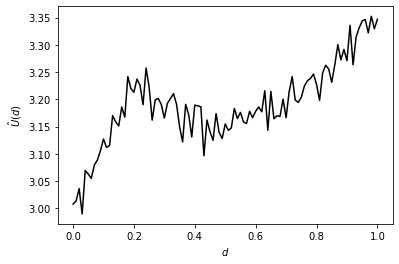

In [9]:
plt.figure()
plt.plot(np.squeeze(d), U_d, '-k')
plt.xlabel('$d$')
plt.ylabel('$\hat{U}(d)$')
plt.show()